## Load In Dependencies

In [1]:
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

# Core Data Science
import numpy as np
import pandas as pd
from scipy import stats,ndimage
from scipy.stats import boxcox,pearsonr,spearmanr,skew
import time
from math import ceil

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Geospatial Analysis
import geopandas as gpd
import rioxarray as rxr
import rasterio
from rasterio.warp import transform_bounds
from rasterio.windows import from_bounds
from osgeo import gdal, osr
from pyproj import CRS
from pyproj import Transformer
from shapely.geometry import Point

# Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from bayes_opt import BayesianOptimization

# Utilities
import os
import re
import glob
from tqdm import tqdm
import json
import joblib
import sys
import concurrent.futures

## Path settings

In [2]:
# Get the working directory of the Notebook and dynamically calculate the project root directory (two levels up)
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))

# Add the project root directory to the module search path so Python can dynamically find the config file
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Import the global instance path_config from path_config.py and rename it as config
from path_config import path_config as config

## Dependent Variable

In [3]:
# Load the training data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv(config.uhi_path)
ground_df.head()

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,24-07-2021 15:53,1.030289
1,-73.909187,40.813045,24-07-2021 15:53,1.030289
2,-73.909215,40.812978,24-07-2021 15:53,1.023798
3,-73.909242,40.812908,24-07-2021 15:53,1.023798
4,-73.909257,40.812845,24-07-2021 15:53,1.021634


## Extracting Band Values from the GeoTIFF Image

In [4]:
#Store the optimal grid resolution in a dictionary

raster_dict = {}

for raster, res in config.rasters_res.items():
    raster_dict[f"{raster}_res_path"] = os.path.join(config.resampled_rasters_path, raster, f"{raster}_res{res}.tif")

raster_names = list(raster_dict.keys())
raster_paths = list(raster_dict.values())

## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_two_datasets</b></i> to combine the predictor variables and response variables.The <i><b>concat</b></i> function from pandas comes in handy here.

In [5]:
def extract_raster(raster_path, csv_path, column_name, global_pbar=None):
    # Load the GeoTIFF data
    data = rxr.open_rasterio(raster_path)
    tiff_crs = data.rio.crs
    
    # Read the CSV file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values
    
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    transformer = Transformer.from_crs("EPSG:4326", tiff_crs, always_xy=True)
    values = []
    
    # Determine whether to use an external progress bar or create a new one
    if global_pbar is None:
        # Create progress bar within the function
        with tqdm(total=len(latitudes), desc="Mapping values") as pbar:
            for lat, lon in zip(latitudes, longitudes):
                # Convert coordinates
                x, y = transformer.transform(lon, lat)
                
                # Use the transformed coordinates to retrieve the value
                value = data.sel(x=x, y=y, method="nearest").values
                # Ensure a single value is obtained
                values.append(float(value[0]))
                
                # Update the progress bar
                pbar.update(1)
    else:
        # Use the externally provided progress bar
        for lat, lon in zip(latitudes, longitudes):
            # Convert coordinates
            x, y = transformer.transform(lon, lat)
            
            # Use the transformed coordinates to retrieve the value
            value = data.sel(x=x, y=y, method="nearest").values
            # Ensure a single value is obtained
            values.append(float(value[0]))
            
            # Update the global progress bar
            global_pbar.update(1)
    
    result_df = pd.DataFrame({column_name: values})
    
    return result_df

# Example usage: for processing multiple raster files or calling this function multiple times
def process_multiple_rasters(raster_paths, csv_path, column_names):
    # Calculate total processing points
    df = pd.read_csv(csv_path)
    total_points = len(df) * len(raster_paths)
    
    # Create a global progress bar
    with tqdm(total=total_points, desc="Mapping values") as global_pbar:
        results = []
        for raster_path, column_name in zip(raster_paths, column_names):
            # Pass the progress bar to the function
            result = extract_raster(raster_path, csv_path, column_name, global_pbar)
            results.append(result)
    
    # Merge all results
    final_df = pd.concat(results, axis=1)
    return final_df

Because the features have been mapped, the following blocks are annotated

In [6]:
# # Create a master table to store all results
# env_xs = pd.read_csv(config.uhi_path)  # Read the original CSV to keep latitude and longitude information

# # Iterate through all raster images and merge results
# for raster_name, raster_path in zip(raster_dict.keys(), raster_dict.values()):
#     env_x = extract_raster(raster_path, config.uhi_path, raster_name)
#     env_xs = pd.concat([env_xs, env_x], axis=1)

In [7]:
# env_xs = env_xs.iloc[:, 4:]
# env_xs

In [8]:
# # Combine two datasets vertically (along columns) using pandas concat function.
# def combine_two_datasets(dataset1,dataset2):
#     data = pd.concat([dataset1,dataset2], axis=1)
#     return data

# # Combining ground data and final data into a single dataset.
# raster_data = combine_two_datasets(ground_df, env_xs)
# raster_data  = raster_data.drop(columns=['Longitude','Latitude','datetime'])
# raster_data

In [9]:
# combined_data = raster_data
# pd.DataFrame.to_csv(combined_data,config.combined_data_path,index=False)

## Feature_Enginnering

In [10]:
combined_data = pd.read_csv(config.combined_data_path)

In [11]:
def check_anomalies(df):
    results = {}
    
    # Check for null values
    null_counts = df.isnull().sum()
    results['Null values'] = null_counts[null_counts > 0]
    
    # Check for infinite values
    inf_mask = df.select_dtypes(include=np.number).isin([np.inf, -np.inf])
    inf_counts = inf_mask.sum()
    results['Infinite values'] = inf_counts[inf_counts > 0]
    
    # Check for zero values
    numeric_cols = df.select_dtypes(include=np.number).columns
    zero_counts = (df[numeric_cols] == 0).sum()
    results['Zero values'] = zero_counts[zero_counts > 0]
    
    # Check for outliers
    outliers = {}
    for col in numeric_cols:
        if df[col].count() > 0:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            out_count = df[(df[col] < lower) | (df[col] > upper)].shape[0]
            if out_count > 0:
                outliers[col] = out_count
    results['Outliers'] = outliers
    
    return results

# Usage example
anomalies = check_anomalies(combined_data)
for anomaly_type, counts in anomalies.items():
    print(f"\n{anomaly_type}:")
    print(counts)



Null values:
forest_hight_res_path    1667
dtype: int64

Infinite values:
Series([], dtype: int64)

Zero values:
Series([], dtype: int64)

Outliers:
{'UHI Index': 11, 'b6_res_path': 243, 'b7_res_path': 433, 'b8_res_path': 125, 'b8a_res_path': 132, 'b9_res_path': 185, 'b11_res_path': 4, 'dem_res_path': 86, 'forest_hight_res_path': 1688, 'mndwi_res_path': 981, 'ndli_res_path': 109, 'ndvi_res_path': 97, 'ndwi_res_path': 17, 'surface_albedo_res_path': 2, 'bnh_res_path': 107, 'hunits_res_path': 166, 'mean_c_occ_res_path': 438, 'vachus_res_path': 984, 'build_cove_res_path': 629, 'build_dens_res_path': 187, 'mean_heigh_res_path': 700, 'popdensity_res_path': 138, 'ndvi_impervious_res_path': 74, 'ndvi_buildcove_res_path': 87, 'greenessres_impervious_res_path': 133, 'ndvi_surfacealbedo_res_path': 1, 'landsatlst_buildcove_res_path': 514, 'landsatlst_meanheigh_res_path': 526, 'popdensity_impervious_res_path': 469, 'popdensity_buildcove_res_path': 122, 'popdensity_builddens_res_path': 375, 'popden

## Stepwise

Because the features have been screened, the following blocks are annotated

In [12]:
# def train_rf_with_feature_selection(data, target_col='UHI Index', test_size=0.3, random_state=42, 
#                                    improvement_threshold=0.0005, n_estimators=200, 
#                                    use_stepwise=True, output_path= config.selected_features_path ):
#     """
#     Train a Random Forest model and select features, with an option to use forward stepwise regression.
#     Whether or not stepwise regression is used, cols_to_keep will be generated and saved.

#     Parameters:
#     - data: Input DataFrame
#     - target_col: Name of the target variable, default is 'UHI Index'
#     - test_size: Proportion of test set, default is 0.3
#     - random_state: Random seed, default is 42
#     - improvement_threshold: Improvement threshold for stepwise regression
#     - n_estimators: Number of trees in the random forest
#     - use_stepwise: Whether to use forward stepwise regression
#     - output_path: Path to save selected features

#     Returns:
#     - final_model: Trained Random Forest model (None if use_stepwise=False)
#     - selected_features: List of selected features
#     - cols_to_keep: List containing target variable and selected features
#     """

#     # 1) Separate features (X) and target (y)
#     X = data.drop(columns=[target_col], axis=1)
#     y = data[target_col]

#     # 2) If you want to directly exclude 3 columns with many NaN values, you can exclude them here
#     exclude_cols = [
#         #'ndvi_div_impervious_res_path',
#         #'landsatlst_div_foresthight_res_path',
#         #'meanheigh_div_foresthight_res_path'
#     ]
#     X.drop(columns=exclude_cols, errors='ignore', inplace=True)

#     # 3) Split train and test sets
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=test_size, random_state=random_state
#     )

#     # === Removed value clipping, infinite value handling, and NaN value handling ===

#     # 4) Define internal function for forward stepwise regression
#     def forward_stepwise_rf(X_train, X_test, y_train, y_test):
#         selected_features = []
#         candidate_features = list(X_train.columns)
        
#         # Calculate baseline model: R² score using mean value prediction
#         baseline_pred = np.full_like(y_test, y_train.mean(), dtype=np.float64)
#         best_score = r2_score(y_test, baseline_pred)
        
#         improvement = True
#         while improvement and candidate_features:
#             improvement = False
#             scores = []
            
#             for feature in candidate_features:
#                 temp_features = selected_features + [feature]
#                 rf_model = RandomForestRegressor(
#                     n_estimators=n_estimators, 
#                     random_state=random_state, 
#                     n_jobs=-1
#                 )
#                 rf_model.fit(X_train[temp_features], y_train)
#                 score = r2_score(y_test, rf_model.predict(X_test[temp_features]))
#                 scores.append((feature, score))
            
#             # Find the feature with the highest score after adding
#             feature_to_add, best_new_score = max(scores, key=lambda x: x[1])
            
#             # If the score improves by at least the threshold, add the feature
#             if best_new_score >= best_score + improvement_threshold:
#                 selected_features.append(feature_to_add)
#                 candidate_features.remove(feature_to_add)
#                 best_score = best_new_score
#                 print(f"After adding {feature_to_add}, R² score: {best_score:.4f}")
#                 improvement = True
#             else:
#                 break
        
#         return selected_features

#     # 5) Perform feature selection (or keep all)
#     if use_stepwise:
#         print("Using forward stepwise regression for feature selection...")
#         selected_features = forward_stepwise_rf(X_train, X_test, y_train, y_test)
        
#         # 6) Train final model
#         final_model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state, n_jobs=-1)
#         final_model.fit(X_train[selected_features], y_train)

#         # 7) Evaluate model
#         y_pred = final_model.predict(X_test[selected_features])
#         final_r2 = r2_score(y_test, y_pred)
#         final_mse = mean_squared_error(y_test, y_pred)

#         print(f"\nFinal selected features: {selected_features}")
#         print(f"Final R² score: {final_r2:.4f}")
#         print(f"Final mean squared error (MSE): {final_mse:.4f}")

#         # 8) Feature importance
#         feature_importance = pd.DataFrame({
#             'Feature': selected_features,
#             'Importance': final_model.feature_importances_
#         }).sort_values('Importance', ascending=False)

#         print("\nFeature importance ranking:")
#         print(feature_importance)
#     else:
#         print("Not using forward stepwise regression, keeping all features...")
#         selected_features = list(X_train.columns)
#         final_model = None  # No model training
#         # Directly generate cols_to_keep and save file
#         print("Directly saving feature file, no model training.")

#     # 9) Generate cols_to_keep (whether or not stepwise regression is used)
#     cols_to_keep = [target_col] + selected_features

#     # 10) Save to CSV
#     pd.DataFrame(cols_to_keep, columns=['Feature']).to_csv(output_path, index=False)
#     print(f"\ncols_to_keep saved to: {output_path}")
#     print(f"cols_to_keep content: {cols_to_keep}")

#     return final_model, selected_features, cols_to_keep


# # --- Example usage ---
# final_model, selected_features, cols_to_keep = train_rf_with_feature_selection(
#     combined_data, 
#     use_stepwise=True,
# )


In [13]:
combined_data_selected = combined_data[config.cols_to_keep]
combined_data_selected

,UHI Index,build_dens_wnh_res_path,anh_res_path,meanheigh_impervious_res_path,ndli_ndvi_res_path,meanheigh_buildcove_res_path,ndvi_res_path
0,1.030289,0.010776,6.239490,3511.822998,0.034178,12.257183,0.132893
1,1.030289,0.010807,6.248621,3510.478760,0.034226,12.288874,0.132796
2,1.023798,0.010807,6.248621,3497.020996,0.034363,12.280379,0.131980
3,1.023798,0.010807,6.248621,3497.020996,0.034363,12.280379,0.131980
4,1.021634,0.010807,6.248621,3483.501953,0.034516,12.270723,0.131129
...,...,...,...,...,...,...,...
11224,0.972470,0.247492,87.046356,5563.712402,0.092404,19.053247,0.263834
11225,0.972470,0.247492,87.046356,5563.712402,0.092404,19.053247,0.263834
11226,0.981124,0.247492,87.046356,5561.086426,0.092891,19.067699,0.264146
11227,0.981245,0.254565,86.915749,5561.086426,0.092891,19.067699,0.264146


### Exploratory Data Analysis

In [14]:
# In order to facilitate drawing presentation, the variable name needs to be modified here

rename_list = config.rename_list

# Get display names for columns and rows
corr_matrix = combined_data_selected.corr(method="spearman")
col_labels = [rename_list.get(col, col) for col in combined_data_selected.columns]
row_labels = [rename_list.get(idx, idx) for idx in combined_data_selected.columns]

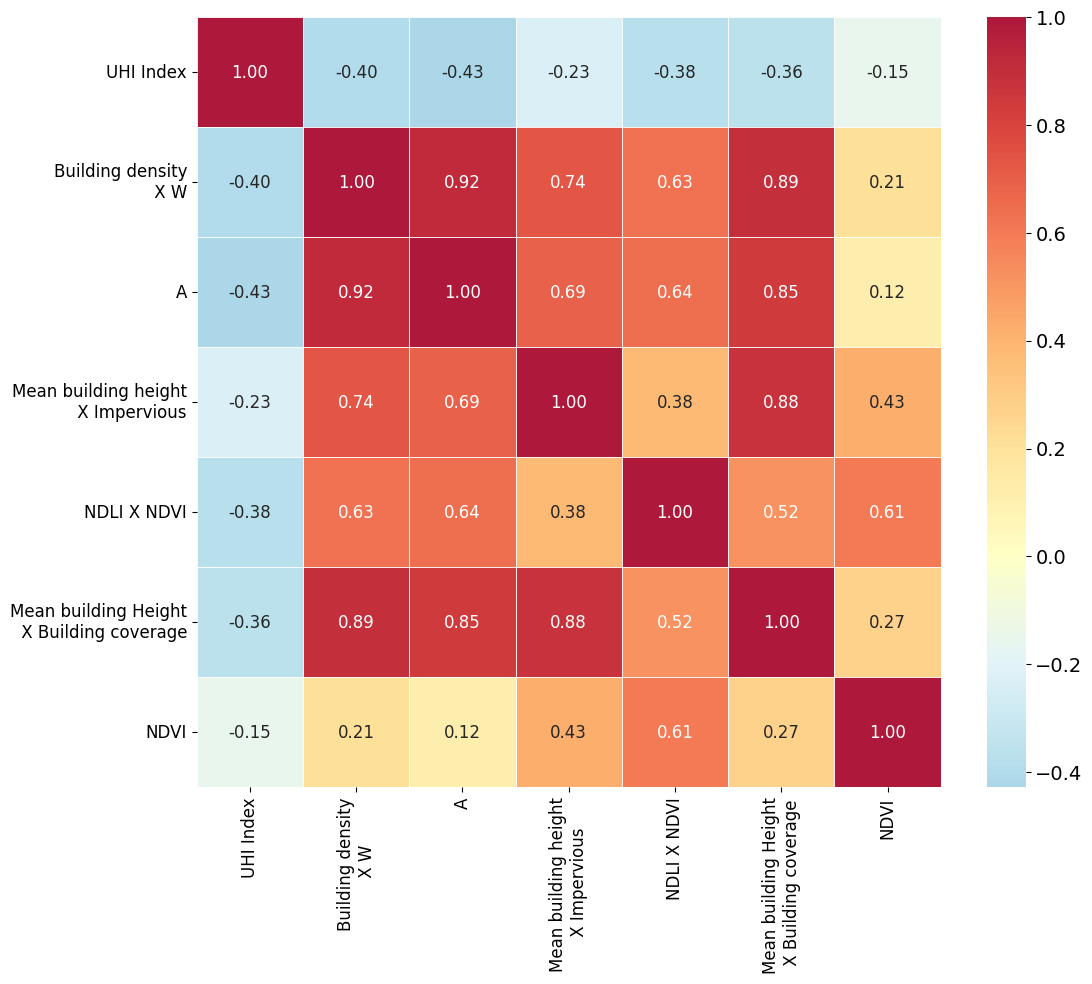

In [15]:
# Plot the full correlation coefficient heatmap with renamed labels
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    corr_matrix,
    annot=True,
    annot_kws={"size": 12},
    cmap="RdYlBu_r",
    center=0,
    linewidths=0.5,
    fmt=".2f",
    xticklabels=col_labels,
    yticklabels=row_labels,
    alpha=0.9  # Make the color lighter
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Make colorbar (legend) tick labels larger
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.savefig(os.path.join(config.figures_path, 'corr_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# Set target variable
target_variable = "UHI Index"

# Filter numeric variables
numeric_columns = combined_data_selected.select_dtypes(include=['number']).columns
numeric_columns = numeric_columns.drop(target_variable, errors='ignore')  # Remove UHI Index itself
num_vars = len(numeric_columns)

In [17]:
# Set digital display mode
def custom_formatter(x, _):
    if x == 0:
        return "0"
    elif abs(x) < 10:
        s = f"{x:.2f}"
        return s
    elif abs(x) < 100:
        s = f"{x:.1f}"
        return s
    elif abs(x) < 1000:
        s = f"{x:.0f}"
        return s
    else:
        s = f"{x:,.0f}" # 加上千分號
        return s

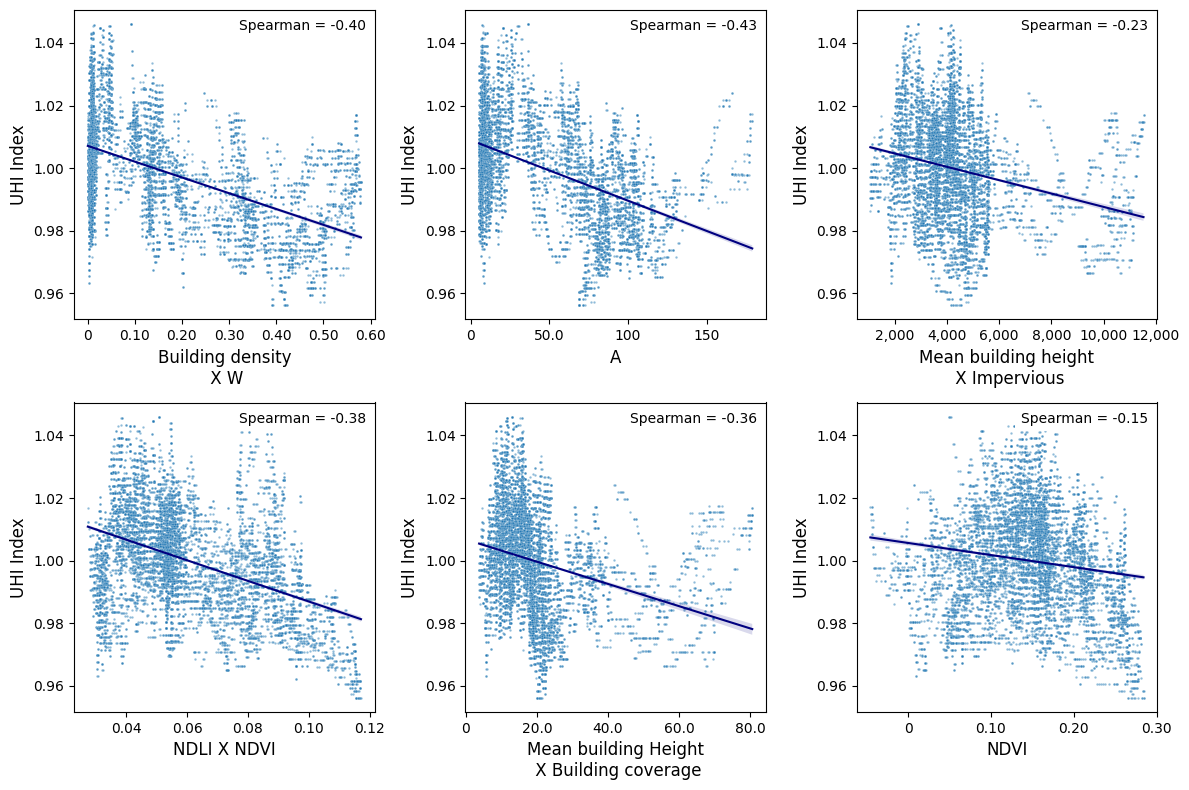

In [18]:
# Set the number of subplot rows and columns
rows, cols = 10, 13  # 10x13 grid layout
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()  # Flatten to 1D array for easy iteration

# Plot scatter plots of UHI Index vs other variables, using renamed labels for x-axis
for i, col in enumerate(numeric_columns):
    x_label = rename_list.get(col, col)
    # Scatter plot
    sns.scatterplot(x=combined_data_selected[col], y=combined_data_selected[target_variable], ax=axes[i], alpha=0.5, s=3)
    # Fit line
    sns.regplot(x=combined_data_selected[col], y=combined_data_selected[target_variable], ax=axes[i], scatter=False, color='navy', line_kws={'linewidth':1.5})
    axes[i].set_xlabel(x_label, fontsize=12)
    axes[i].set_ylabel(target_variable, fontsize=12)
    axes[i].tick_params(axis='both', which='major', labelsize=10)
    # Set x-axis to use thousands separator
    axes[i].get_xaxis().set_major_formatter(plt.FuncFormatter(custom_formatter))
    # Calculate Spearman correlation and annotate at the top right
    spearman_corr = combined_data_selected[[col, target_variable]].corr(method='spearman').iloc[0, 1]
    axes[i].text(
        0.97, 0.97, f"Spearman = {spearman_corr:.2f}",
        transform=axes[i].transAxes,
        ha='right', va='top',
        fontsize=10, color='black',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none')
    )

# Remove extra empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(os.path.join(config.figures_path, 'scatter_plot.png'), dpi=300, bbox_inches='tight')
plt.show()

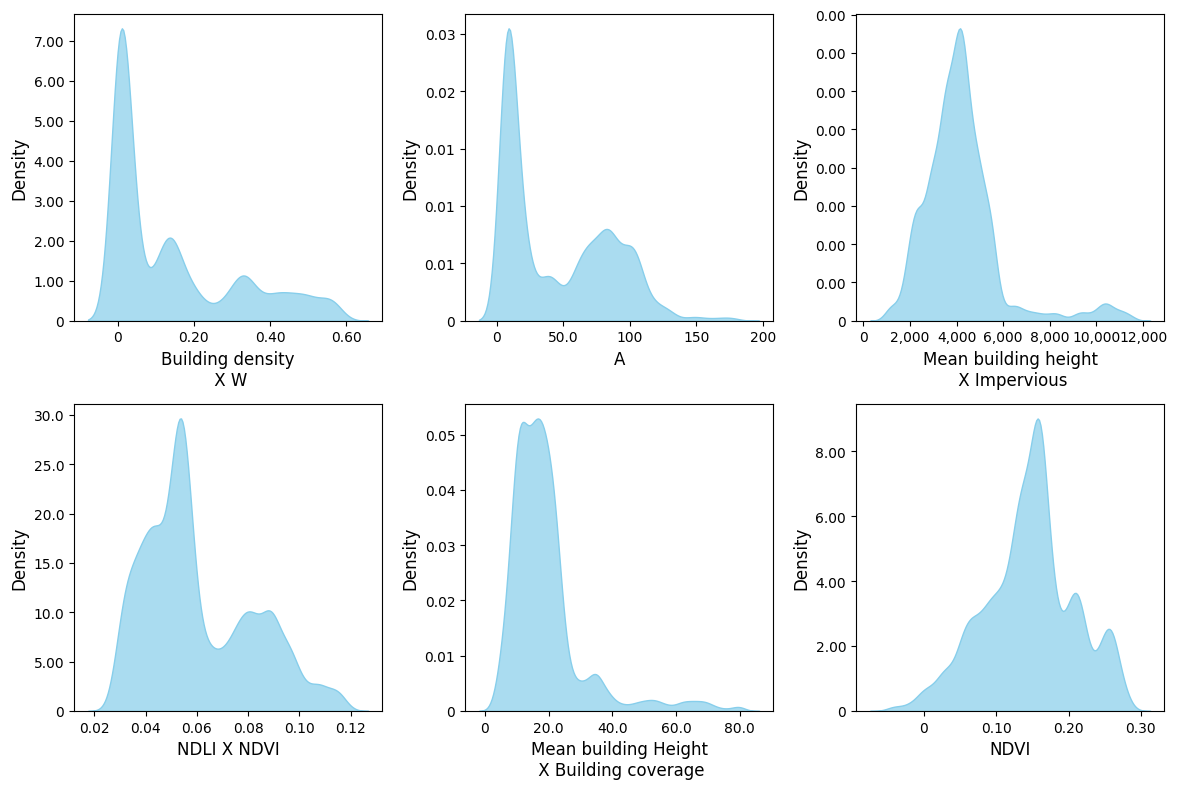

In [19]:
# Set the number of subplot rows and columns
rows, cols = 10, 13  # 10x13 grid layout
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()  # Flatten to 1D array for easy iteration

# Plot histograms of each numeric variable, using renamed labels for x-axis
for i, col in enumerate(numeric_columns):
    x_label = rename_list.get(col, col)
    sns.kdeplot(combined_data_selected[col], ax=axes[i], color='skyblue', fill=True, alpha=0.7)
    axes[i].set_xlabel(x_label, fontsize=12)
    axes[i].set_ylabel("Density", fontsize=12)
    axes[i].tick_params(axis='both', which='major', labelsize=10)
    # Custom formatter: show 2 decimals if <1 and not 0, but drop trailing zero if second decimal is 0; else integer


    axes[i].get_xaxis().set_major_formatter(plt.FuncFormatter(custom_formatter))
    axes[i].get_yaxis().set_major_formatter(plt.FuncFormatter(custom_formatter))

# Remove extra empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(os.path.join(config.figures_path, 'kde_plot.png'), dpi=300, bbox_inches='tight')
plt.show()

In [20]:
skewness_df = combined_data_selected.skew()
print(skewness_df)

UHI Index                        0.025482
build_dens_wnh_res_path          1.099582
anh_res_path                     0.613994
meanheigh_impervious_res_path    1.856659
ndli_ndvi_res_path               0.677358
meanheigh_buildcove_res_path     2.414273
ndvi_res_path                   -0.171480
dtype: float64


In [21]:
transform_list = ['build_dens_wnh_res_path','meanheigh_impervious_res_path','meanheigh_buildcove_res_path']

In [22]:
pt = PowerTransformer(method='box-cox', standardize=False)

In [23]:
# Perform Box-Cox transformation and update the original dataframe
transformed_data = pt.fit_transform(combined_data_selected[transform_list])

# Print the transformation method and lambda for each variable
lambdas = []
for col, lam in zip(transform_list, pt.lambdas_):
    print(f"{col}: Box-Cox (lambda={lam:.4f})")
    lambdas.append(lam)

combined_data_selected_transformed = combined_data_selected.copy()

# Replace the original columns with the transformed data
combined_data_selected_transformed[transform_list] = transformed_data

combined_data_selected_transformed

build_dens_wnh_res_path: Box-Cox (lambda=0.0397)
meanheigh_impervious_res_path: Box-Cox (lambda=0.0037)
meanheigh_buildcove_res_path: Box-Cox (lambda=-0.1872)


,UHI Index,build_dens_wnh_res_path,anh_res_path,meanheigh_impervious_res_path,ndli_ndvi_res_path,meanheigh_buildcove_res_path,ndvi_res_path
0,1.030289,-4.146193,6.239490,8.288464,0.034178,2.000319,0.132893
1,1.030289,-4.143790,6.248621,8.288070,0.034226,2.001934,0.132796
2,1.023798,-4.143790,6.248621,8.284111,0.034363,2.001502,0.131980
3,1.023798,-4.143790,6.248621,8.284111,0.034363,2.001502,0.131980
4,1.021634,-4.143790,6.248621,8.280119,0.034516,2.001010,0.131129
...,...,...,...,...,...,...,...
11224,0.972470,-1.358358,87.046356,8.763112,0.092404,2.265169,0.263834
11225,0.972470,-1.358358,87.046356,8.763112,0.092404,2.265169,0.263834
11226,0.981124,-1.358358,87.046356,8.762625,0.092891,2.265605,0.264146
11227,0.981245,-1.331688,86.915749,8.762625,0.092891,2.265605,0.264146


In [24]:
# Convert lambdas to a dict, with keys as column names from transform_list and values as the corresponding lambdas
lambda_dict = {col: lam for col, lam in zip(transform_list, lambdas)}
print(lambda_dict)
lambda_json_path = os.path.join(config.data_dir, "lambda_dict.json")
with open(lambda_json_path, "w") as f:
    json.dump(lambda_dict, f, indent=4)
print(f"lambda_dict saved to {lambda_json_path}")

{'build_dens_wnh_res_path': 0.039719504840685, 'meanheigh_impervious_res_path': 0.0037006486456058296, 'meanheigh_buildcove_res_path': -0.1872066353090951}
lambda_dict saved to D:\EY_2025\model\data\lambda_dict.json


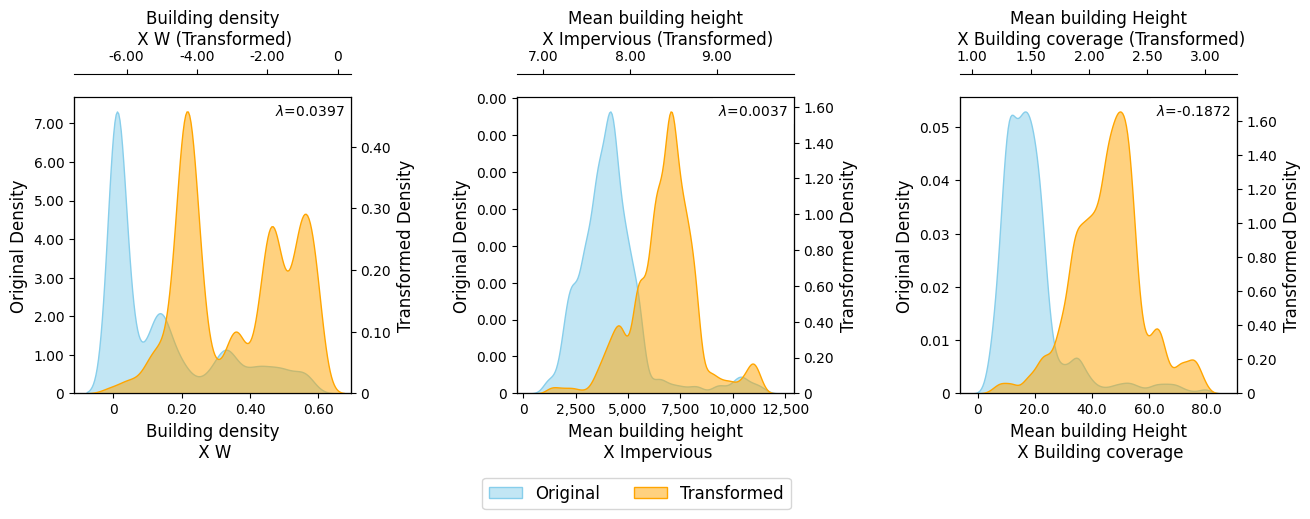

In [25]:
fig, axes = plt.subplots(1, len(transform_list), figsize=(5 * len(transform_list), 4))
if len(transform_list) == 1:
    axes = [axes]

handles = []
labels = []

for i, col in enumerate(transform_list):
    x_label = rename_list.get(col, col)
    ax_orig = axes[i]  # Axis for original data (bottom x and left y)

    # KDE for original data
    sns.kdeplot(
        combined_data_selected[col],
        ax=ax_orig,
        color='skyblue',
        fill=True,
        alpha=0.5,
        label='Original' if i == 0 else None
    )
    ax_orig.set_xlabel(x_label, fontsize=12)
    ax_orig.set_ylabel("Original Density", fontsize=12)
    ax_orig.tick_params(axis='both', which='major', labelsize=10)
    ax_orig.get_xaxis().set_major_formatter(plt.FuncFormatter(custom_formatter))
    ax_orig.get_yaxis().set_major_formatter(plt.FuncFormatter(custom_formatter))

    # Set margin for transformed axis (Method B: add 15% padding)
    x_min = combined_data_selected_transformed[col].min()
    x_max = combined_data_selected_transformed[col].max()
    pad   = (x_max - x_min) * 0.15 if x_max > x_min else 0

    ax_top = ax_orig.twiny()
    ax_top.spines['top'].set_position(('axes', 1.08))
    ax_top.set_xlim(x_min - pad, x_max + pad)
    ax_top.set_xlabel(f"{x_label} (Transformed)", fontsize=12)
    ax_top.tick_params(axis='x')
    ax_top.get_xaxis().set_major_formatter(plt.FuncFormatter(custom_formatter))

    # Right y-axis for transformed KDE
    ax_tr = ax_top.twinx()
    sns.kdeplot(
        combined_data_selected_transformed[col],
        ax=ax_tr,
        color='orange',
        fill=True,
        alpha=0.5,
        label='Transformed' if i == 0 else None
    )
    ax_tr.set_ylabel("Transformed Density", fontsize=12)
    ax_tr.tick_params(axis='y')
    ax_tr.get_yaxis().set_major_formatter(plt.FuncFormatter(custom_formatter))

    # 在右上角標註 lambda
    lambda_val = lambdas[i]
    ax_orig.text(
        0.98, 0.98, f"$\\lambda$={lambda_val:.4f}",
        transform=ax_orig.transAxes,
        ha='right', va='top',
        fontsize=10, color='black',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
    )

    # Collect legend handles and labels (only once)
    if i == 0:
        h1, l1 = ax_orig.get_legend_handles_labels()
        h2, l2 = ax_tr.get_legend_handles_labels()
        handles = h1 + h2
        labels = l1 + l2

# Layout and legend
fig.subplots_adjust(wspace=0.6, top=0.85)
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=12,
           bbox_to_anchor=(0.5, -0.2))
plt.savefig(os.path.join(config.figures_path, 'kde_plot_transformed.png'), dpi=300, bbox_inches='tight')
plt.show()

In [26]:
pd.DataFrame.to_csv(combined_data_selected_transformed,config.training_data_path,index=False)

In [27]:
!jupyter nbconvert --to script build_features.ipynb

[NbConvertApp] Converting notebook build_features.ipynb to script
[NbConvertApp] Writing 22541 bytes to build_features.py
